In [22]:
from pylsl import StreamInlet, resolve_stream
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft, fftfreq

In [23]:
N_channels = 8

## LSL Receiver

In [24]:
print("looking for an EEG stream...")
streams = resolve_stream('type', 'EEG')

# create a new inlet to read from the stream
inlet = StreamInlet(streams[0])
data = []
while True:
    # get a new sample (you can also omit the timestamp part if you're not
    # interested in it)
    chunk, timestamps = inlet.pull_chunk()
    if timestamps:
        data.extend(chunk)
    if len(data) > 1000:
        break

print(data)
# print(time)

write_data = ','.join([str(item) for item in data])
f = open('sample.csv', 'w')
f.write(write_data)
f.close()

looking for an EEG stream...


KeyboardInterrupt: 

In [ ]:
# Read ~1000 samples data from csv
data = []
with open('sample.csv', 'r') as f:
    data = f.read()

data = data.strip('[]').split('],[')

# String => string list => float64 list
data = [list(map(lambda x: np.float64(x), row.split(', '))) for row in data]
# List of lists => 2D array
data = np.array(list(map(np.array, data)))
data

array([[-2.89634991e+00, -8.81654993e-02, -4.12458467e+00, ...,
        -3.84856415e+00,  1.15541935e+00, -1.99999999e-08],
       [ 2.12177634e+00, -1.56250548e+00, -5.87953711e+00, ...,
         4.41357946e+00,  1.43930882e-01,  1.99999999e-08],
       [ 6.72393036e+00, -4.13564730e+00, -8.50016594e+00, ...,
         7.35286951e+00, -1.57814634e+00, -1.99999999e-08],
       ...,
       [ 2.81618214e+01,  1.40138607e+01,  7.91414022e+00, ...,
        -1.05797348e+01,  1.28833227e+01, -1.99999999e-08],
       [ 4.35782700e+01,  1.84454327e+01,  8.74043560e+00, ...,
        -5.92623046e-03,  1.19669685e+01,  1.99999999e-08],
       [ 5.21309662e+01,  2.12825203e+01,  1.19548550e+01, ...,
         1.12630939e+01,  1.11298380e+01, -1.99999999e-08]])

## Plot Received Data

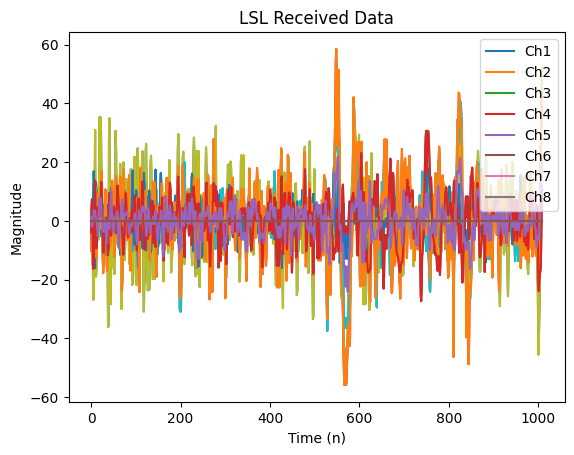

In [ ]:
labels = [f'Ch{i}' for i in range(1, 9)]
plt.plot(data)

plt.title('LSL Received Data')
plt.ylabel('Magnitude')
plt.xlabel('Time (n)')
plt.plot(data)
plt.legend(labels)

## FFT

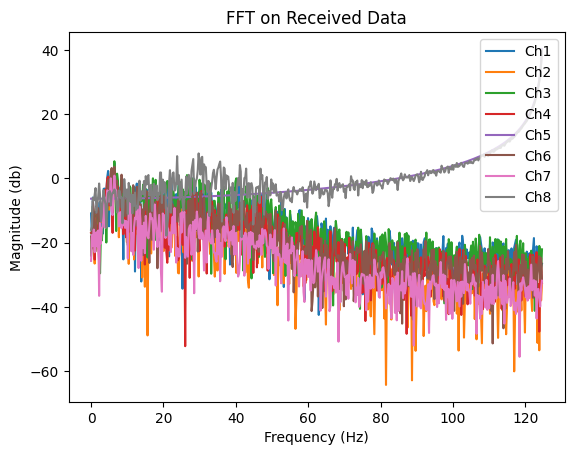

In [ ]:
# Sample count
N_samples = len(data)

# Sampling rate
fs = 250

# Sample spacing (inverse of sampling rate)
df = 1/fs

'''
FFT and frequency time scale
Halve the frequency domain b/c real time signal conjugate symmetry
'''
def trunc_fft(channel_data: np.array) -> np.array:
    return fft(channel_data)[:N_samples//2]

yfs = np.apply_along_axis(trunc_fft, 0, data)
xf = fftfreq(N_samples, df)[:N_samples//2]

'''
Voltage to decibel
'''
def volt_to_dec(arr: np.array) -> np.array:
    dec_array = 20*np.log10(np.abs(arr)/np.max(arr))
    dec_array -= dec_array[0]
    return dec_array

yfs = np.apply_along_axis(volt_to_dec, 0, yfs)

plt.title('FFT on Received Data')
plt.ylabel('Magnitude (db)')
plt.xlabel('Frequency (Hz)')
plt.plot(xf, yfs)
plt.legend(labels)

looking for an EEG stream...
1


IndexError: index 5 is out of bounds for axis 1 with size 5

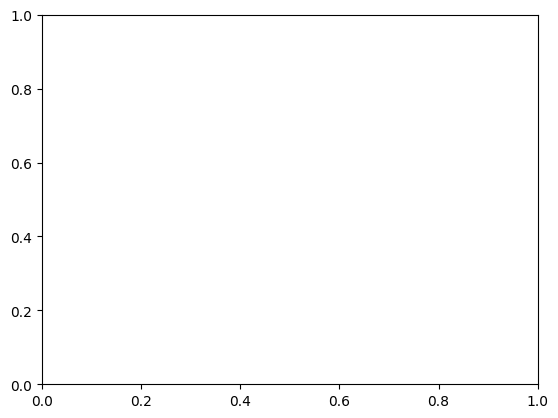

2023-04-19 20:47:25.155 ( 888.731s) [R_bci           ]      data_receiver.cpp:342    ERR| Stream transmission broke off (Input stream error.); re-connecting...


In [ ]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from pylsl import StreamInlet, resolve_stream, resolve_byprop
from scipy.fft import fft, ifft, fftfreq

%matplotlib inline

print("looking for an EEG stream...")
# streams = resolve_stream('type', 'EEG')
streams = resolve_byprop('name', 'bci', timeout=2.5)
print(len(streams))

fig = plt.figure()
ax = fig.add_subplot(111)

# create a new inlet to read from the stream
inlet = StreamInlet(streams[0])
N = 8
data = []

while True:
    # get a new sample (you can also omit the timestamp part if you're not
    # interested in it)
    chunk, timestamps = inlet.pull_chunk()
    # print(np.array(chunk).shape)

    if timestamps:
        data.extend(chunk)
    # print(data.shape)
    if len(data) > 500:
        data = data[-500:]

        # print(len(data))

        # Sample count
        N = len(data)
        # Sampling rate
        fs = 250

        # Sample spacing (inverse of sampling rate)
        df = 1/fs

        '''
        FFT and frequency time scale
        Halve the frequency domain due to real-time signal conjugate symmetry
        '''
        data_array = np.array(data)
        # print(data_array.shape)


        yfs = [fft(data_array[:, i])[:N//2] for i in range(8)]
        xf = fftfreq(N, df)[:N//2]
        # xf = xf[xf > 3]
        # xf = xf[xf < 8]

        '''
        Convert power signal to normalized decibel
        '''
        yf_plot = [20*np.log10(np.abs(yf)/np.max(yf)) for yf in yfs]
        # print(yf_plot[0])
        for i in range(8):
            yf_plot[i] -= yf_plot[i][0]
            # yf_plot[i] = yf_plot[i][xf > 3]
            
            yf_plot[i][xf > 8] = 0
            yf_plot[i][xf < 3] = 0
            yf_plot[i] = yf_plot[i][xf < 8]
            # yf_plot[i] = yf_plot[i][xf > 2]
            # yf_plot[i] = yf_plot[i][:len(xf)]

        # xf = xf[xf > 3]
        xf = xf[xf < 8]
        # xf = xf[xf > 2]

        ax.clear()
        
        # ax.plot(data)
        # ax.set_ylim(-30, 30)
        ax.set_ylim(-80, 80)
        # print(yf_plot.shape)

        for i in range(8):
            ax.plot(xf, yf_plot[i], label=f'Ch{i}')
        display(fig)
        ax.legend()
        clear_output(wait=True)
    # plt.pause(0.1)


KeyboardInterrupt: 

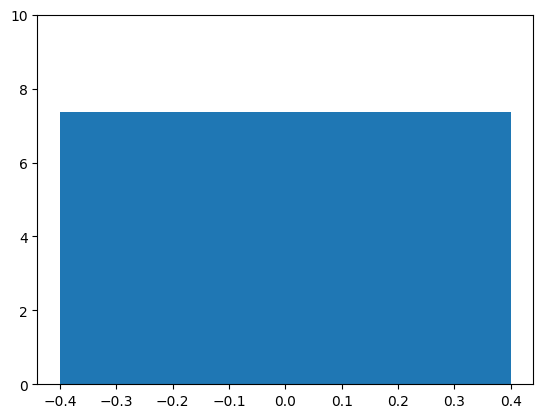

2023-04-30 13:06:05.565 (6875.389s) [R_bci           ]      data_receiver.cpp:342    ERR| Stream transmission broke off (Input stream error.); re-connecting...
2023-04-30 13:06:05.578 (6875.401s) [R_bci           ]      data_receiver.cpp:342    ERR| Stream transmission broke off (Input stream error.); re-connecting...


In [61]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from pylsl import StreamInlet, resolve_stream, resolve_byprop
from scipy.fft import fft, ifft, fftfreq

streams = resolve_stream('type', 'EEG')
# streams = resolve_byprop('name', 'bci', timeout=2.5)

fig = plt.figure()
ax = fig.add_subplot(111)

# create a new inlet to read from the stream
inlet = StreamInlet(streams[0])

# Parameters
N = 8
SLICE = 100
FS = 250
df = 1 / FS

# Our data is stored here
'''
t0: [ch1, ch2, ... ch8]
t1: [ch1, ch2, ... ch8]
.
.
.
tn: [ch1, ch2, ..., ch8]
'''
data = []
timestamps = []

file = open('theta.csv', 'w+')
while True:
    # Get a sample
    '''
    Chunk:
    [[ch1], [ch2], [ch3], ..., [ch8]]
    =>
    [ch1, ch2, ch3, ... ch8]
    '''
    chunk, timestamps = inlet.pull_chunk()

    # We get a valid chunk
    if timestamps:
        # Converts chunk into 
        chunk = list(np.array(chunk).flatten())

        # If we have all channels, add to data time series
        if len(chunk) == N:
            data.append(chunk)

    # If we have at least SLICE number of data points
    if len(data) > SLICE:
        # Circular buffer
        data = data[-SLICE:]

        # Calculation on SLICE-sized buffer
        # y_values = np.mean(np.array(data), axis=0)
        ys = [fft(np.array(data)[:, i])[:SLICE//2] for i in range(N)] # List comprehension + scipy.fft
        
        data_array = np.array(data)
        '''
        ch1: [...]
        ch2: [...]
        ..
        chn: [...]
        '''
        ys = [fft(data_array[:, i])[:SLICE//2] for i in range(N)]
        xs = fftfreq(SLICE, df)[:SLICE//2] # X-axis for FFT, N//2 because complex conjugate symmetry

        '''
        Convert power signal to normalized decibel
        '''
        ys = [20*np.log10(np.abs(y)/np.max(y)) for y in ys]


        # Performs Theta-band filtering 3-8 Hz
        for i in range(N):
            
            ys[i][xs > 8] = 0
            ys[i][xs < 3] = 0
            ys[i] = ys[i][xs < 8]
            ys[i] -= np.min(ys[i])

        xs = xs[xs < 8]
        
        for i in range(N):
            ys[i] = ys[i][xs > 1]

        xs = xs[xs > 1]

        ys = np.array(ys)
        theta_power = np.abs(np.mean(ys.flatten()))
        file.write('f{theta_power},')

        ys = ys.T
        # print(xs.shape)
        # Plotting
        ax.clear()
        ax.set_ylim(0, 10)
        # ax.plot(xs, ys)
        # print(theta_power)
        ax.bar([0], theta_power)
        
        # print(theta_power)
        display(fig)
        # for i in range(N):
        #     ax.plot(xs, ys[i], label=f'Ch{i}')
        # ax.legend()
        clear_output(wait=True)
